![](/banner.png)

![](banner.png)

# Objetivos
+ Cargar los datos de una base de datos oltp y realizar limpieza
+ Perfilar los datos recibidos
+ Conseguir un conjunto de datos relacionado con toda la información a excluyendo municipio
+ Conseguir un conjunto de datos relacionado únicamente con los totales por municipio en cada año

# Carga de librerias

In [1]:
#Librerias para trabajar los datos
import pandas as pd
import numpy as np

#Librerias para visualizar los datos
import matplotlib.pyplot as plt
import seaborn as sns

#Otras
import math

# Carga de datos

In [2]:
#Carga de los datos principales
df_main = pd.read_csv('sources/data_2010_2017.csv',sep=',',index_col=False,low_memory=False)
#Carga de información adicional de latitudes y longitudes de departamentos
df_depto = pd.read_csv('sources/colombia_depto.csv',sep=',', header=None, encoding='utf8') 
df_depto.columns = ["codigo_depto","nombre_depto","lati_depto", "long_depto"]
#Carga de información adicional del # de población por depto
df_poblacion_depto = pd.read_csv('sources/poblacion_deptos.csv',sep=',',index_col=False)
#Carga de información adicional del # de población por año, edad y sexo
df_poblacion_datos = pd.read_csv('sources/poblacion_datos.csv',sep=';',index_col=False, encoding='latin-1')

In [3]:
df_main.head()

,anio,codigo_depto,nombre_depto,nombre_muni,codigo_muni,codigo_evento,evento,edad,sexo,num_casos
0,2010,TOTAL,TOTAL,TOTAL,TOTAL,TOTAL,TOTAL,TOTAL,TOTAL,200524.0
1,2010,TOTAL,TOTAL,TOTAL,TOTAL,TOTAL,TOTAL,TOTAL,Hombres,114264.0
2,2010,TOTAL,TOTAL,TOTAL,TOTAL,TOTAL,TOTAL,TOTAL,Mujeres,86250.0
3,2010,TOTAL,TOTAL,TOTAL,TOTAL,TOTAL,TOTAL,TOTAL,Indeterminado,10.0
4,2010,TOTAL,TOTAL,TOTAL,TOTAL,TOTAL,TOTAL,Menor 1 año,Hombres,4745.0


# Limpieza y Perfilamiento
## Datos principales
En principio vamos a eliminar los elementos que calculan totales en el dataframe para que todas las filas representen lo mismo

In [4]:
df_main = df_main.drop(df_main[df_main['codigo_depto']=='TOTAL'].index)
df_main = df_main.drop(df_main[df_main['nombre_depto']=='TOTAL'].index)
df_main = df_main.drop(df_main[df_main['nombre_muni']=='TOTAL'].index)
df_main = df_main.drop(df_main[df_main['codigo_muni']=='TOTAL'].index)
df_main = df_main.drop(df_main[df_main['codigo_evento']=='TOTAL'].index)
df_main = df_main.drop(df_main[df_main['evento']=='TOTAL'].index)
df_main = df_main.drop(df_main[df_main['edad']=='TOTAL'].index)
df_main = df_main.drop(df_main[df_main['sexo']=='TOTAL'].index)

Luego revisamos los tipos de datos y transformamos lo que sea necesario

In [5]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 464634 entries, 1750 to 1244983
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   anio           464634 non-null  int64  
 1   codigo_depto   464634 non-null  object 
 2   nombre_depto   464634 non-null  object 
 3   nombre_muni    464634 non-null  object 
 4   codigo_muni    464634 non-null  object 
 5   codigo_evento  464634 non-null  object 
 6   evento         464634 non-null  object 
 7   edad           464634 non-null  object 
 8   sexo           464634 non-null  object 
 9   num_casos      464634 non-null  float64
dtypes: float64(1), int64(1), object(8)
memory usage: 55.1+ MB


In [6]:
def arreglar_tipos(v_types:dict) -> None:
    for value in v_types:
        try:
            df_main[value] = df_main[value].astype(v_types[value])
        except Exception as e:
            print(f'error in value {value}',str(e))
        
value_types = {'anio':'int64','codigo_depto':'int64','nombre_depto':'string',
               'nombre_muni':'string','codigo_muni':'int64','codigo_evento':'int64',
               'evento':'string','sexo':'string','edad':'string','num_casos':'int64'
              }

arreglar_tipos(value_types)

error in value codigo_depto invalid literal for int() with base 10: 'Extranjeros'


Vemos que en la columna codigo_depto hay un elemento llamado 'Extranjeros', asi que lo vamos a cambiar por el código 100

In [7]:
df_main['codigo_depto'] = df_main['codigo_depto'].apply(lambda x : 100 if x == 'Extranjeros' else x)

Volvemos a intentar

In [8]:
arreglar_tipos(value_types)

Todo correcto

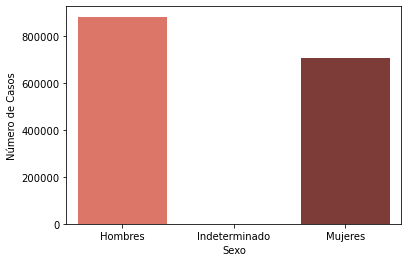

In [9]:
temp = df_main.groupby(by=["sexo"]).sum().reset_index()
temp_fig = sns.barplot(y="num_casos", x="sexo", data=temp, palette="Reds_d")
temp_fig.set(xlabel='Sexo', ylabel='Número de Casos')
plt.show()

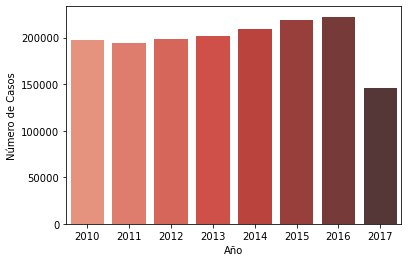

In [10]:
temp = df_main.groupby(by=["anio"]).sum().reset_index()
temp_fig = sns.barplot(y="num_casos", x="anio", data=temp, palette="Reds_d")
temp_fig.set(xlabel='Año', ylabel='Número de Casos')
plt.show()

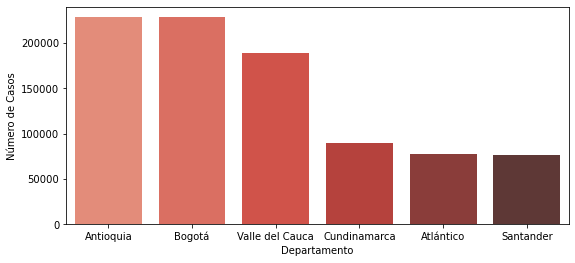

In [11]:
temp = df_main.groupby(by=["nombre_depto"]).sum().reset_index().sort_values(by="num_casos",ascending=False)
plt.figure(figsize=(9,4))
temp_fig = sns.barplot(y="num_casos", x="nombre_depto", data=temp, palette="Reds_d", order = temp["nombre_depto"][0:6])
temp_fig.set(xlabel='Departamento', ylabel='Número de Casos')
plt.show()

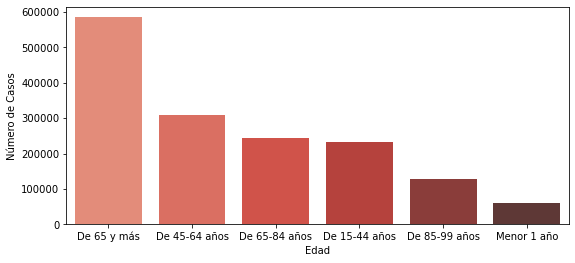

In [12]:
temp = df_main.groupby(by=["edad"]).sum().reset_index().sort_values(by="num_casos",ascending=False)
plt.figure(figsize=(9,4))
temp_fig = sns.barplot(y="num_casos", x="edad", data=temp, palette="Reds_d", order = temp["edad"][0:6])
temp_fig.set(xlabel='Edad', ylabel='Número de Casos')
plt.show()

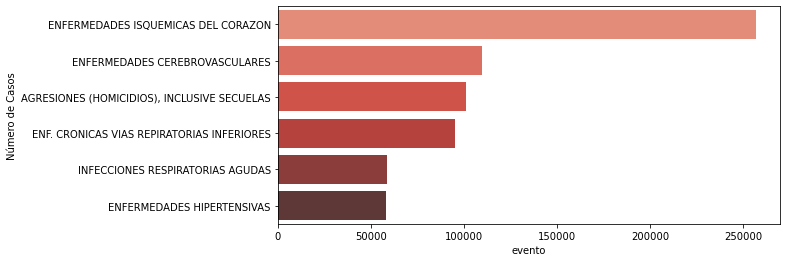

In [13]:
temp = df_main.groupby(by=["evento"]).sum().reset_index().sort_values(by="num_casos",ascending=False)
plt.figure(figsize=(9,4))
temp_fig = sns.barplot(y="evento", x="num_casos", data=temp, palette="Reds_d", order = temp["evento"][0:6])
temp_fig.set(xlabel='evento', ylabel='Número de Casos')
plt.show()

## Datos de departamento

In [14]:
df_depto.head()

,codigo_depto,nombre_depto,lati_depto,long_depto
0,91,Amazonas,-1.019722,-71.938333
1,5,Antioquia,7.000000,-75.500000
2,81,Arauca,7.090278,-70.761667
3,8,Atlántico,10.750000,-75.000000
4,13,Bolívar,9.000000,-74.333333


Luego revisamos los tipos de datos y transformamos lo que sea necesario

In [15]:
df_depto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   codigo_depto  33 non-null     int64  
 1   nombre_depto  33 non-null     object 
 2   lati_depto    33 non-null     float64
 3   long_depto    33 non-null     float64
dtypes: float64(2), int64(1), object(1)
memory usage: 1.2+ KB


Todo correcto

<AxesSubplot:xlabel='long_depto', ylabel='lati_depto'>

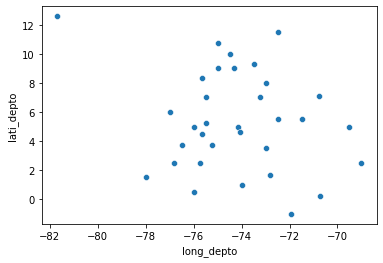

In [16]:
temp = df_depto[["lati_depto","long_depto"]]
sns.scatterplot(data=temp, x="long_depto", y="lati_depto")

## Datos de población por depto

In [17]:
df_poblacion_depto.head(3)

,departamento,población
0,Amazonas,79020
1,Antioquia,6677930
2,Arauca,391020


Luego revisamos los tipos de datos y transformamos lo que sea necesario

In [18]:
df_poblacion_depto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   departamento  33 non-null     object
 1   población     33 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 656.0+ bytes


Todo correcto

## Datos de población por edad, sexo y año

In [19]:
df_poblacion_datos.head()

,anio,edad,poblacion,sexo
0,2010,80+ años,245286,Hombres
1,2010,75-79 años,248086,Hombres
2,2010,70-74 años,353204,Hombres
3,2010,65-69 años,471137,Hombres
4,2010,60-64 años,656599,Hombres


Luego revisamos los tipos de datos y transformamos lo que sea necesario

In [20]:
df_poblacion_datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272 entries, 0 to 271
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   anio       272 non-null    int64 
 1   edad       272 non-null    object
 2   poblacion  272 non-null    int64 
 3   sexo       272 non-null    object
dtypes: int64(2), object(2)
memory usage: 8.6+ KB


Todo correcto

# Transformaciones
En caso de no contar con la cantidad de población determinada para algún grupo vamos a retirar esta información por lo que retiraremos los valores referentes a:
+ Muertes en el extranjero (columna codigo_depto con el valor 100)
+ Muertes de sexo indeterminado (columna sexo con el valor "Indeterminado")
+ Muertes de edad desconocida (columna edad con valor "Edad Desconocida")

In [21]:
df_main = df_main.drop(df_main[df_main['codigo_depto']==100].index)
df_main = df_main.drop(df_main[df_main['sexo']=='Indeterminado'].index)
df_main = df_main.drop(df_main[df_main['edad']=='Edad desconocida'].index)

En la columna edad quitaremos los valores correspondientes a "De 65 y más" dado que en esa columna a la vez hay rangos como "De 65-84 años", "De 85-99 años", "De 100 y más" y al ser dos versiones de la misma información (aparentemente), decidimos quedarnos con los otros rangos en espera de que nos den más info.

In [22]:
df_main = df_main.drop(df_main[df_main['edad']=='De 65 y más'].index)

## Conseguimos el numero de personas por S,E,A
Vamos a conseguir un numero de personas por sexo, edad y año

In [23]:
#Df temporal con main
df1 = df_main.copy()
#Df temporal con datos
df2 = df_poblacion_datos.copy()

Agrupamos para hallar el numero de casos sin discriminar por municipio

In [24]:
df1 = df1.groupby(['sexo','anio','edad','codigo_depto','nombre_depto','codigo_evento','evento']).sum()
df1.head(5)

codigo_muni  \
sexo    anio edad        codigo_depto nombre_depto codigo_evento evento                                                        
Hombres 2010 De 1-4 años 5            Antioquia    101           ENFERMEDADES INFECCIOSAS INTESTINALES                  5051   
                                                   103           CIERTAS ENF. TRANSMITIDAS POR VECTORES Y RABIA         5854   
                                                   105           MENINGITIS                                             5001   
                                                   106           SEPTICEMIA                                             5647   
                                                   109           INFECCIONES RESPIRATORIAS AGUDAS                      48994   

                                                                                                                 num_casos  
sexo    anio edad        codigo_depto nombre_depto codigo_evento evento                                                     
Hombres 2010 De 1-4 años 5            Antioquia    101           ENFERMEDADES INFECCIOSAS INTESTINALES                   1  
                                                   103           CIERTAS ENF. TRANSMITIDAS POR VECTORES Y RABIA          1  
                                                   105           MENINGITIS                                              2  
                                                   106           SEPTICEMIA                                              1  
                                                   109           INFECCIONES RESPIRATORIAS AGUDAS                        9

Arreglamos el indice y quitamos codigo_muni

In [25]:
df1 = df1.reset_index()
df1 = df1.drop(columns=["codigo_muni"])

In [26]:
df1.head(5)

,sexo,anio,edad,codigo_depto,nombre_depto,codigo_evento,evento,num_casos
0,Hombres,2010,De 1-4 años,5,Antioquia,101,ENFERMEDADES INFECCIOSAS INTESTINALES,1
1,Hombres,2010,De 1-4 años,5,Antioquia,103,CIERTAS ENF. TRANSMITIDAS POR VECTORES Y RABIA,1
2,Hombres,2010,De 1-4 años,5,Antioquia,105,MENINGITIS,2
3,Hombres,2010,De 1-4 años,5,Antioquia,106,SEPTICEMIA,1
4,Hombres,2010,De 1-4 años,5,Antioquia,109,INFECCIONES RESPIRATORIAS AGUDAS,9


In [27]:
df1.tail(5)

,sexo,anio,edad,codigo_depto,nombre_depto,codigo_evento,evento,num_casos
74859,Mujeres,2017,Menor 1 año,99,Vichada,404,TRAST. RESPIRATORIOS ESPECIFICOS DEL PERIODO P...,1
74860,Mujeres,2017,Menor 1 año,99,Vichada,405,SEPSIS BACTERIANA DEL RECIEN NACIDO,2
74861,Mujeres,2017,Menor 1 año,99,Vichada,602,DEFICIENCIAS NUTRICIONALES Y ANEMIAS NUTRICION...,4
74862,Mujeres,2017,Menor 1 año,99,Vichada,615,"MALFORMACIONES CONGEN., DEFORMID.Y ANOMALIAS C...",1
74863,Mujeres,2017,Menor 1 año,99,Vichada,700,"SINTOMAS, SIGNOS Y AFECCIONES MAL DEFINIDAS",1


In [28]:
df1["edad"].value_counts()

De 45-64 años    19872
De 15-44 años    18228
Menor 1 año       8695
De 65-84 años     7608
De 5-14 años      6881
De 1-4 años       6125
De 85-99 años     6063
De 100 y más      1392
Name: edad, dtype: int64

Vamos a crear una columna en el dataframe df1 y en el dataframe df_población_datos que nos ayude a hacer la relación que queremos para mapear rangos de edad

In [29]:
rangos_df1 = {'Menor 1 año':'0-4 años','De 1-4 años':'0-4 años',
              'De 5-14 años':'5-14 años','De 15-44 años':'15-44 años',
              'De 15-44 años':'15-44 años','De 45-64 años':'45-64 años',
              'De 65-84 años':'65+ años', 'De 65 y más':'65+ años',
              'De 85-99 años':'65+ años','De 100 y más':'65+ años'
             }

df1['edad'] = df1['edad'].apply(lambda x : rangos_df1[x])

In [30]:
rangos_datos = {'80+ años':'65+ años','75-79 años':'65+ años',
                '70-74 años':'65+ años','65-69 años':'65+ años',
                '60-64 años':'45-64 años','55-59 años':'45-64 años',
                '50-54 años':'45-64 años','45-49 años':'45-64 años',
                '40-45 años':'15-44 años','35-40 años':'15-44 años',
                '30-34 años':'15-44 años','25-29 años':'15-44 años',
                '20-24 años':'15-44 años','15-19 años':'15-44 años',
                '10-14 años':'5-14 años','5-9 años':'5-14 años',
                '0-4 años':'0-4 años'
             }

df2['edad'] = df2['edad'].apply(lambda x : rangos_datos[x])

Para df2 los elementos que en edad tengan el mismo valor ahora deben ser sumados

In [31]:
df2 = df2.groupby(by=['edad','anio','sexo']).sum()
#Para volverlo dataframe denuevo
df2 = df2.reset_index()

In [32]:
#Df temporal con la union de los anteriores
df3 = pd.merge(df1, df2,  on=['edad','anio','sexo'])

In [33]:
df3.tail()

,sexo,anio,edad,codigo_depto,nombre_depto,codigo_evento,evento,num_casos,poblacion
74859,Mujeres,2017,5-14 años,86,Putumayo,510,"OTROS ACCIDENTES, INCLUSIVE SECUELAS",1,3817407
74860,Mujeres,2017,5-14 años,86,Putumayo,512,"AGRESIONES (HOMICIDIOS), INCLUSIVE SECUELAS",1,3817407
74861,Mujeres,2017,5-14 años,91,Amazonas,700,"SINTOMAS, SIGNOS Y AFECCIONES MAL DEFINIDAS",1,3817407
74862,Mujeres,2017,5-14 años,95,Guaviare,609,"APENDICITIS, HERNIA CAVIDAD ABDOMINAL Y OBSTR....",1,3817407
74863,Mujeres,2017,5-14 años,99,Vichada,506,AHOGAMIENTO Y SUMERSION ACCIDENTALES,1,3817407


## Conseguimos el porcentaje de personas por departamento

In [34]:
#Df temporal con la información del departamento
df4 = df_poblacion_depto.copy()
#cambiamos el nombre de las columnas
df4.columns = ["nombre_depto","poblacion"]

In [35]:
tot_poblacion = df4['poblacion'].sum()

In [36]:
df4['porcentaje'] = df4['poblacion'].apply(lambda x : x/tot_poblacion)

In [37]:
df4.head()

,nombre_depto,poblacion,porcentaje
0,Amazonas,79020,0.001564
1,Antioquia,6677930,0.132211
2,Arauca,391020,0.007742
3,Atlántico,2722128,0.053893
4,Bogotá,7743955,0.153317


## Juntamos con la info anterior
Juntamos todo para conseguir personas por sexo, año, edad y departemento

In [38]:
df5 = pd.merge(df3,df4,on=["nombre_depto"], suffixes = ("_l","_r"))

In [39]:
df5.head()

,sexo,anio,edad,codigo_depto,nombre_depto,codigo_evento,evento,num_casos,poblacion_l,poblacion_r,porcentaje
0,Hombres,2010,0-4 años,5,Antioquia,101,ENFERMEDADES INFECCIOSAS INTESTINALES,1,1959813,6677930,0.132211
1,Hombres,2010,0-4 años,5,Antioquia,103,CIERTAS ENF. TRANSMITIDAS POR VECTORES Y RABIA,1,1959813,6677930,0.132211
2,Hombres,2010,0-4 años,5,Antioquia,105,MENINGITIS,2,1959813,6677930,0.132211
3,Hombres,2010,0-4 años,5,Antioquia,106,SEPTICEMIA,1,1959813,6677930,0.132211
4,Hombres,2010,0-4 años,5,Antioquia,109,INFECCIONES RESPIRATORIAS AGUDAS,9,1959813,6677930,0.132211


Multiplicamos población_l con porcentaje para hallar cuantas personas con determinado sexo, año y edad son de cierto departamento, luego redondeamos

In [40]:
df5["poblacion"] = df5["poblacion_l"] * df5["porcentaje"]
df5["poblacion"] = df5["poblacion"].apply(lambda x : math.ceil(x))

Podemos dropear las columnas sobrantes

In [41]:
df5 = df5.drop(columns=['poblacion_l','poblacion_r','porcentaje'])

In [42]:
df5

,sexo,anio,edad,codigo_depto,nombre_depto,codigo_evento,evento,num_casos,poblacion
0,Hombres,2010,0-4 años,5,Antioquia,101,ENFERMEDADES INFECCIOSAS INTESTINALES,1,259110
1,Hombres,2010,0-4 años,5,Antioquia,103,CIERTAS ENF. TRANSMITIDAS POR VECTORES Y RABIA,1,259110
2,Hombres,2010,0-4 años,5,Antioquia,105,MENINGITIS,2,259110
3,Hombres,2010,0-4 años,5,Antioquia,106,SEPTICEMIA,1,259110
4,Hombres,2010,0-4 años,5,Antioquia,109,INFECCIONES RESPIRATORIAS AGUDAS,9,259110
...,...,...,...,...,...,...,...,...,...
74218,Mujeres,2017,45-64 años,99,Vichada,213,RESIDUO DE TUMORES MALIGNOS,1,11921
74219,Mujeres,2017,45-64 años,99,Vichada,214,"CARCINOMA IN-SITU, T. BENIGNOS Y DE COMPORTAM....",3,11921
74220,Mujeres,2017,45-64 años,99,Vichada,303,ENFERMEDADES ISQUEMICAS DEL CORAZON,1,11921
74221,Mujeres,2017,45-64 años,99,Vichada,612,ENFERMEDADES SISTEMA URINARIO,1,11921


## Normalizamos con la proporción casos/población
Tomamos casos/1000 habitantes, casos/10000 habitantes y casos/100000 habitantes

In [43]:
#Copia de df5
df6 = df5.copy()

In [44]:
df6["c/1000"] = df6["num_casos"] / df6["poblacion"] * 1000
df6["c/1000"] = df6["c/1000"].apply(lambda x : round(x,5))
df6["c/10000"] = df6["num_casos"] / df6["poblacion"] * 10000
df6["c/10000"] = df6["c/10000"].apply(lambda x : round(x,5))
df6["c/100000"] = df6["num_casos"] / df6["poblacion"] * 100000
df6["c/100000"] = df6["c/100000"].apply(lambda x : round(x,5))

In [45]:
df6.tail(3)

,sexo,anio,edad,codigo_depto,nombre_depto,codigo_evento,evento,num_casos,poblacion,c/1000,c/10000,c/100000
74220,Mujeres,2017,45-64 años,99,Vichada,303,ENFERMEDADES ISQUEMICAS DEL CORAZON,1,11921,0.08389,0.83886,8.38856
74221,Mujeres,2017,45-64 años,99,Vichada,612,ENFERMEDADES SISTEMA URINARIO,1,11921,0.08389,0.83886,8.38856
74222,Mujeres,2017,5-14 años,99,Vichada,506,AHOGAMIENTO Y SUMERSION ACCIDENTALES,1,8538,0.11712,1.17123,11.71234


Ahora si numero de casos y población pueden ser dropeados

In [46]:
df6 = df6.drop(columns=['num_casos','poblacion'])

Guardamos

In [47]:
df6.to_csv('generated/data_deptos.csv', index = False)

# Datos Resultado

In [48]:
df6.groupby(by=['sexo']).mean()

,anio,codigo_depto,codigo_evento,c/1000,c/10000,c/100000
sexo,,,,,,
Hombres,2013.883192,43.069796,391.465012,0.149449,1.494485,14.944853
Mujeres,2013.900507,42.228612,384.977387,0.112037,1.120373,11.203725


In [49]:
#df.groupby(by='sexo')['num_casos'].sum()

In [50]:
#df.groupby(by='evento')['num_casos'].sum().sort_values()

In [51]:
#df.loc[df['sexo']=='Indeterminado']['evento'].value_counts()

In [52]:
#df.groupby(by='edad')['num_casos'].sum().sort_values()

In [53]:
#df.groupby(by='nombre_depto')['num_casos'].sum().sort_values()